In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../dataset/')
sys.path.append('/home/kirill/Учеба/asbestos/src/')
from dataset import load_img
from utils import get_paths_from_dirs
import os
import cv2
from dataset import AsbestosDataSet
from albumentations import Resize,Normalize
from albumentations import functional as F
from catalyst import dl, metrics, utils;
from models import Attention_Unet, Unet
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import albumentations as A
from models.utils import TverskyLoss 

In [2]:
dataset = AsbestosDataSet('/home/kirill/Учеба/asbestos/PitStonesData/48_macro_asbest_resize/images',
                          '/home/kirill/Учеба/asbestos/PitStonesData/48_macro_asbest_resize/segmentation', 
                          [Resize(64,64)],
                          preload_data = False
)

In [5]:
# dataset = AsbestosDataSet('/home/kirill/Учеба/asbestos/PitStonesData/48_test/image',
#                           '/home/kirill/Учеба/asbestos/PitStonesData/48_test/segmentation', 
#                           A.Compose([A.Resize(128,128)]),
#                           preload_data = True
# )


dataset = AsbestosDataSet('/home/kirill/Учеба/asbestos/PitStonesData/lab_common_test/image/',
                          '/home/kirill/Учеба/asbestos/PitStonesData/lab_common_test/segmentation/', 
                          A.Compose([A.Resize(128,128)]),
                          preload_data = True
)

In [6]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
    def forward(self, inputs, targets, smooth=1e-5):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        return 1 - dice

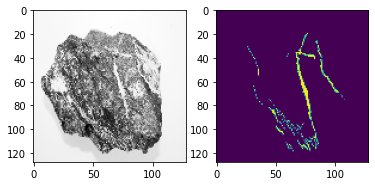

In [12]:
n = 8
img = dataset[n]['image']
mask = dataset[n]['mask']
fig, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap="Greys_r")
ax[1].imshow(mask)

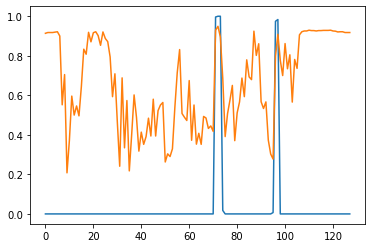

In [13]:
plt.plot(mask[62,])
plt.plot(img[62,])

In [19]:
class CustomRunner(dl.Runner):
    def predict_batch(self, batch):
        return self.model(batch['image'].to(self.device))
    def on_loader_start(self, runner):
        super().on_loader_start(runner)
        self.meters = { key: metrics.AdditiveValueMetric(compute_on_call=True)
                        for key in ["loss", "iou"]}
        
    def handle_batch(self, batch):
        image, mask, name = batch.values()
        image = image.unsqueeze(1)
        mask  = mask.unsqueeze(1)
        predict = self.model(image)#batch size
        loss = self.criterion(predict, mask)
        #Создаем обьект
        iou_metric = metrics.IOUMetric()
        iou = iou_metric.update_key_value(predict, mask)['iou']
        self.batch_metrics.update(
            {"loss": loss, "iou": iou}
        )
        for key in ["loss", "iou"]:
            self.meters[key].update( self.batch_metrics[key].item(), self.batch_size)
        iou_metric.reset()
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
    def on_loader_end(self, runner):
        for key in ["loss", "iou"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)   

In [20]:
unet = Unet(n_channels=1, n_classes = 1 )
unet = Attention_Unet(1,1)

torch.Size([8, 128, 128])


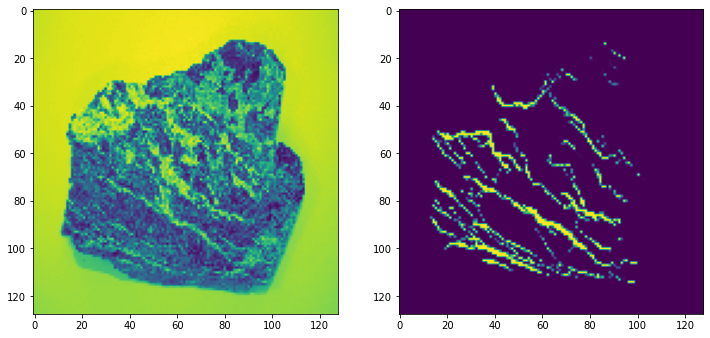

In [21]:
loader  = {"train":DataLoader(dataset, batch_size = 8)}
img = next(iter(loader['train']))['image']
img.shape

image, mask, name = next(iter(loader['train'])).values()
image = (image - image.mean())/image.std()
mask  = (mask - mask.mean())/mask.std()
print(image.shape)
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].imshow(image[0].detach().numpy())
ax[1].imshow(mask[0].detach().numpy())

In [22]:
# criterion = DiceLoss()
criterion = TverskyLoss()
optimizer = Adam(unet.parameters())
runner = CustomRunner()
runner.train(
    model=unet,
    criterion = criterion,
    optimizer=optimizer,
    loaders=loader,
    num_epochs=200,
    logdir = 'log_tversky_lb',
    verbose=True)



train (1/200) iou: 0.03674047915399939 | loss: 0.9294554763945981
* Epoch (1/200) 



train (2/200) iou: 0.05004465893126916 | loss: 0.9050768579261891
* Epoch (2/200) 



train (3/200) iou: 0.05855591082270595 | loss: 0.8898677860481151
* Epoch (3/200) 



train (4/200) iou: 0.07010655412855356 | loss: 0.86968775935795
* Epoch (4/200) 



train (5/200) iou: 0.09324565411045932 | loss: 0.8305426991504172
* Epoch (5/200) 



train (6/200) iou: 0.13229433490314343 | loss: 0.7680628498395283
* Epoch (6/200) 



train (7/200) iou: 0.17281701102636865 | loss: 0.7073543685069981
* Epoch (7/200) 



train (8/200) iou: 0.21552876221097034 | loss: 0.6472748543905177
* Epoch (8/200) 



train (9/200) iou: 0.2368288517430209 | loss: 0.6191220266231592
* Epoch (9/200) 



train (10/200) iou: 0.26811010163763294 | loss: 0.5788067872973456
* Epoch (10/200) 



train (11/200) iou: 0.2730295781208121 | loss: 0.5730580765268077
* Epoch (11/200) 



train (12/200) iou: 0.2997837336598963 | loss: 0.5406579124754753
* Epoch (12/200) 



train (13/200) iou: 0.32146645974421845 | loss: 0.5156137770500736
* Epoch (13/200) 



train (14/200) iou: 0.32123859593833703 | loss: 0.5157545053440592
* Epoch (14/200) 



train (15/200) iou: 0.33654127820678376 | loss: 0.49962198561516363
* Epoch (15/200) 



train (16/200) iou: 0.34883766502573876 | loss: 0.4851287275120832
* Epoch (16/200) 



train (17/200) iou: 0.36708280876062915 | loss: 0.4653072521306466
* Epoch (17/200) 



train (18/200) iou: 0.38005997434906336 | loss: 0.4518846981767295
* Epoch (18/200) 



train (19/200) iou: 0.3756537549737571 | loss: 0.4568978764008785
* Epoch (19/200) 



train (20/200) iou: 0.36967628978300787 | loss: 0.4628435537435006
* Epoch (20/200) 



train (21/200) iou: 0.4039196445458177 | loss: 0.42755441302838537
* Epoch (21/200) 



train (22/200) iou: 0.4198911017265872 | loss: 0.411541828210803
* Epoch (22/200) 



train (23/200) iou: 0.42602658660515497 | loss: 0.40588342193244153
* Epoch (23/200) 



train (24/200) iou: 0.4390395378720933 | loss: 0.39384145926738134
* Epoch (24/200) 



train (25/200) iou: 0.43913531476172857 | loss: 0.39335257851559186
* Epoch (25/200) 



train (26/200) iou: 0.44298231904057483 | loss: 0.390154430831688
* Epoch (26/200) 



train (27/200) iou: 0.43889116981755144 | loss: 0.3939989615177763
* Epoch (27/200) 



train (28/200) iou: 0.4531280851882437 | loss: 0.38055784719577734
* Epoch (28/200) 



train (29/200) iou: 0.4413736972255983 | loss: 0.39121010683584906
* Epoch (29/200) 



train (30/200) iou: 0.42426183258277783 | loss: 0.40729145122611005
* Epoch (30/200) 



train (31/200) iou: 0.45406856225884473 | loss: 0.3795344829559327
* Epoch (31/200) 



train (32/200) iou: 0.4634576591028684 | loss: 0.3711819208186606
* Epoch (32/200) 



train (33/200) iou: 0.4781607259874758 | loss: 0.35823232367418817
* Epoch (33/200) 



train (34/200) iou: 0.4776963323786639 | loss: 0.3580515376035719
* Epoch (34/200) 



train (35/200) iou: 0.4992813584597215 | loss: 0.3394160080647122
* Epoch (35/200) 



train (36/200) iou: 0.5043816959512406 | loss: 0.33492927706759906
* Epoch (36/200) 



train (37/200) iou: 0.5041206362454788 | loss: 0.33489509682724444
* Epoch (37/200) 



train (38/200) iou: 0.5047491620416227 | loss: 0.334491226984107
* Epoch (38/200) 



train (39/200) iou: 0.5123243992743285 | loss: 0.3275554983512215
* Epoch (39/200) 



train (40/200) iou: 0.5188237402750099 | loss: 0.322175277316052
* Epoch (40/200) 



train (41/200) iou: 0.5250879845757415 | loss: 0.3169107748114545
* Epoch (41/200) 



train (42/200) iou: 0.5215872331805852 | loss: 0.32019480328628985
* Epoch (42/200) 



train (43/200) iou: 0.5193628185037252 | loss: 0.3224098086357116
* Epoch (43/200) 



train (44/200) iou: 0.5263109816157299 | loss: 0.31607614392819605
* Epoch (44/200) 



train (45/200) iou: 0.5194826748060144 | loss: 0.32135406179704523
* Epoch (45/200) 



train (46/200) iou: 0.5234353870585345 | loss: 0.3183041586392167
* Epoch (46/200) 



train (47/200) iou: 0.5344525800235029 | loss: 0.30904837535775226
* Epoch (47/200) 



train (48/200) iou: 0.5363891638707422 | loss: 0.306961931180263
* Epoch (48/200) 



train (49/200) iou: 0.5425973141538923 | loss: 0.30203339500703674
* Epoch (49/200) 



train (50/200) iou: 0.5384494852328646 | loss: 0.3058539991793425
* Epoch (50/200) 



train (51/200) iou: 0.5447738900564719 | loss: 0.30031968286071997
* Epoch (51/200) 



train (52/200) iou: 0.5417661537294802 | loss: 0.30297831262367364
* Epoch (52/200) 



train (53/200) iou: 0.5511937603570413 | loss: 0.29483066520829126
* Epoch (53/200) 



train (54/200) iou: 0.552667103383852 | loss: 0.29385564033535944
* Epoch (54/200) 



train (55/200) iou: 0.5558067603387693 | loss: 0.2914310158162877
* Epoch (55/200) 



train (56/200) iou: 0.5566311651381893 | loss: 0.29089217686998675
* Epoch (56/200) 



train (57/200) iou: 0.5407733087954314 | loss: 0.3025623663612034
* Epoch (57/200) 



train (58/200) iou: 0.5407335611357205 | loss: 0.30271146694819134
* Epoch (58/200) 



train (59/200) iou: 0.5592264019060826 | loss: 0.28820083625074755
* Epoch (59/200) 



train (60/200) iou: 0.5655797750189685 | loss: 0.2828220180843187
* Epoch (60/200) 



train (61/200) iou: 0.5705725079861239 | loss: 0.2793287021526392
* Epoch (61/200) 



train (62/200) iou: 0.5637769375158392 | loss: 0.28405711789062055
* Epoch (62/200) 



train (63/200) iou: 0.5729282429252847 | loss: 0.27675241145534785
* Epoch (63/200) 



train (64/200) iou: 0.5707703561022661 | loss: 0.27837400332741125
* Epoch (64/200) 



train (65/200) iou: 0.5780538303264674 | loss: 0.27307918365450873
* Epoch (65/200) 



train (66/200) iou: 0.5877784274626469 | loss: 0.26508668540180597
* Epoch (66/200) 



train (67/200) iou: 0.5959670837374701 | loss: 0.25870545273241785
* Epoch (67/200) 



train (68/200) iou: 0.6002968126449032 | loss: 0.25525779136713
* Epoch (68/200) 



train (69/200) iou: 0.6012846041416777 | loss: 0.25429341499356256
* Epoch (69/200) 



train (70/200) iou: 0.5931881476139677 | loss: 0.2609099978985994
* Epoch (70/200) 



train (71/200) iou: 0.6017604513444762 | loss: 0.253791087779446
* Epoch (71/200) 



train (72/200) iou: 0.6082323806873267 | loss: 0.2490553527638532
* Epoch (72/200) 



train (73/200) iou: 0.6111866814502771 | loss: 0.24658257978549902
* Epoch (73/200) 



train (74/200) iou: 0.6146474238755045 | loss: 0.24357487671617145
* Epoch (74/200) 



train (75/200) iou: 0.611381679341413 | loss: 0.24581735548765762
* Epoch (75/200) 



train (76/200) iou: 0.6065650556398476 | loss: 0.24980435423229058
* Epoch (76/200) 



train (77/200) iou: 0.6119584069735763 | loss: 0.24587262281473132
* Epoch (77/200) 



train (78/200) iou: 0.5921437619388967 | loss: 0.2609082831852679
* Epoch (78/200) 



train (79/200) iou: 0.6032850811446923 | loss: 0.2524393710537233
* Epoch (79/200) 



train (80/200) iou: 0.6141319983247397 | loss: 0.2440213958422343
* Epoch (80/200) 



train (81/200) iou: 0.6156916912051215 | loss: 0.24289333042891126
* Epoch (81/200) 



train (82/200) iou: 0.619586083336153 | loss: 0.2398666255715964
* Epoch (82/200) 



train (83/200) iou: 0.6279031141944554 | loss: 0.23368234133374863
* Epoch (83/200) 



train (84/200) iou: 0.6243433088496112 | loss: 0.23638259241546408
* Epoch (84/200) 



train (85/200) iou: 0.6331253552782362 | loss: 0.22963330711143604
* Epoch (85/200) 



train (86/200) iou: 0.6292274706605552 | loss: 0.23260053258011307
* Epoch (86/200) 



train (87/200) iou: 0.6326432202173318 | loss: 0.2298291472421176
* Epoch (87/200) 



train (88/200) iou: 0.6280874411265055 | loss: 0.2329266062681226
* Epoch (88/200) 



train (89/200) iou: 0.6312126387720522 | loss: 0.2307949593101722
* Epoch (89/200) 



train (90/200) iou: 0.6232696426087533 | loss: 0.23667811656343765
* Epoch (90/200) 



train (91/200) iou: 0.6262796754422395 | loss: 0.23427842838176782
* Epoch (91/200) 



train (92/200) iou: 0.6234485239222431 | loss: 0.23650805587353912
* Epoch (92/200) 



train (93/200) iou: 0.6273274888163028 | loss: 0.23385658039562943
* Epoch (93/200) 



train (94/200) iou: 0.6327045672181724 | loss: 0.22991680667020273
* Epoch (94/200) 



train (95/200) iou: 0.6246849903161975 | loss: 0.23535881094310596
* Epoch (95/200) 



train (96/200) iou: 0.6279812584752621 | loss: 0.23319617561672046
* Epoch (96/200) 



train (97/200) iou: 0.6341130076975062 | loss: 0.22856005119240802
* Epoch (97/200) 



train (98/200) iou: 0.6345614618149358 | loss: 0.2281398488127667
* Epoch (98/200) 



train (99/200) iou: 0.640934381795966 | loss: 0.223373924476513
* Epoch (99/200) 



train (100/200) iou: 0.6456050138542617 | loss: 0.21990004052286563
* Epoch (100/200) 



train (101/200) iou: 0.6459714010141898 | loss: 0.2195394721584044
* Epoch (101/200) 



train (102/200) iou: 0.6512442473052205 | loss: 0.21568249273991238
* Epoch (102/200) 



train (103/200) iou: 0.6533989197965981 | loss: 0.2140621931656547
* Epoch (103/200) 



train (104/200) iou: 0.6520477723384248 | loss: 0.21496576157169064
* Epoch (104/200) 



train (105/200) iou: 0.6509191281553628 | loss: 0.21598926920821698
* Epoch (105/200) 



train (106/200) iou: 0.6502731572026792 | loss: 0.2162355642387832
* Epoch (106/200) 



train (107/200) iou: 0.649979287299557 | loss: 0.21647561978602758
* Epoch (107/200) 



train (108/200) iou: 0.652515531450078 | loss: 0.21488722079042077
* Epoch (108/200) 



train (109/200) iou: 0.6579876619836561 | loss: 0.21080953746602157
* Epoch (109/200) 



train (110/200) iou: 0.6563100089197573 | loss: 0.21174203226531763
* Epoch (110/200) 



train (111/200) iou: 0.6561685506848322 | loss: 0.2120087302249411
* Epoch (111/200) 



train (112/200) iou: 0.656631836856621 | loss: 0.2118309641229934
* Epoch (112/200) 



train (113/200) iou: 0.6574898819992506 | loss: 0.21087036616560342
* Epoch (113/200) 



train (114/200) iou: 0.6585996107778688 | loss: 0.21025772284770355
* Epoch (114/200) 



train (115/200) iou: 0.6591055816498356 | loss: 0.20987410389858743
* Epoch (115/200) 



train (116/200) iou: 0.6582028779430664 | loss: 0.2102664173513219
* Epoch (116/200) 



train (117/200) iou: 0.6647786506708118 | loss: 0.20563574718392413
* Epoch (117/200) 



train (118/200) iou: 0.6634058762287749 | loss: 0.20641156642333322
* Epoch (118/200) 



train (119/200) iou: 0.6593228880909906 | loss: 0.2089646363603896
* Epoch (119/200) 



train (120/200) iou: 0.6649560055870941 | loss: 0.20542407122211184
* Epoch (120/200) 



train (121/200) iou: 0.6693848138270171 | loss: 0.20199684388395667
* Epoch (121/200) 



train (122/200) iou: 0.6752683770829353 | loss: 0.1977413590403571
* Epoch (122/200) 



train (123/200) iou: 0.6762309609979824 | loss: 0.1970376061356586
* Epoch (123/200) 



train (124/200) iou: 0.679224249245464 | loss: 0.19498688155326294
* Epoch (124/200) 



train (125/200) iou: 0.6815150172814078 | loss: 0.19345046299091287
* Epoch (125/200) 



train (126/200) iou: 0.6807167961977529 | loss: 0.19394080448841702
* Epoch (126/200) 



train (127/200) iou: 0.6809734166532323 | loss: 0.1937564585519874
* Epoch (127/200) 



train (128/200) iou: 0.6803341922552688 | loss: 0.19425140602001242
* Epoch (128/200) 



train (129/200) iou: 0.6773288880569346 | loss: 0.19630361639935034
* Epoch (129/200) 



train (130/200) iou: 0.6778231686440067 | loss: 0.19582247906836908
* Epoch (130/200) 



train (131/200) iou: 0.677398927833723 | loss: 0.19615711422934048
* Epoch (131/200) 



train (132/200) iou: 0.6762298077776813 | loss: 0.19680968402088556
* Epoch (132/200) 



train (133/200) iou: 0.6790886590446251 | loss: 0.19491721063420392
* Epoch (133/200) 



train (134/200) iou: 0.6805823868599491 | loss: 0.19387526011121445
* Epoch (134/200) 



train (135/200) iou: 0.6808395135229911 | loss: 0.1938331654106361
* Epoch (135/200) 



train (136/200) iou: 0.6823590138684148 | loss: 0.1926829469376716
* Epoch (136/200) 



train (137/200) iou: 0.6838153462479082 | loss: 0.1914593603300012
* Epoch (137/200) 



train (138/200) iou: 0.6861885483714119 | loss: 0.18991410991419916
* Epoch (138/200) 



train (139/200) iou: 0.6874874683393949 | loss: 0.18900737123212955
* Epoch (139/200) 



train (140/200) iou: 0.6887706751408784 | loss: 0.18805207549661826
* Epoch (140/200) 



train (141/200) iou: 0.690324016239332 | loss: 0.18693499202313626
* Epoch (141/200) 



train (142/200) iou: 0.6911956996157548 | loss: 0.18626431451327563
* Epoch (142/200) 



train (143/200) iou: 0.6907100686128589 | loss: 0.18667551227237872
* Epoch (143/200) 



train (144/200) iou: 0.6926614970400713 | loss: 0.18521066593087238
* Epoch (144/200) 



train (145/200) iou: 0.694613306418709 | loss: 0.18370411447856738
* Epoch (145/200) 



train (146/200) iou: 0.6944700177165045 | loss: 0.1838334384171859
* Epoch (146/200) 



train (147/200) iou: 0.6958903635757557 | loss: 0.18281683541726376
* Epoch (147/200) 



train (148/200) iou: 0.6965636904688848 | loss: 0.18233889254970828
* Epoch (148/200) 



train (149/200) iou: 0.6981200342592986 | loss: 0.18129150159117105
* Epoch (149/200) 



train (150/200) iou: 0.6984509722046228 | loss: 0.18103990606639697
* Epoch (150/200) 



train (151/200) iou: 0.6967796355053998 | loss: 0.18213752300842947
* Epoch (151/200) 



train (152/200) iou: 0.6992875173471976 | loss: 0.18037775547608087
* Epoch (152/200) 



train (153/200) iou: 0.6978519558906556 | loss: 0.1813912832218668
* Epoch (153/200) 



train (154/200) iou: 0.6986749958300936 | loss: 0.1807859669560971
* Epoch (154/200) 



train (155/200) iou: 0.6989301667697188 | loss: 0.18057247693987857
* Epoch (155/200) 



train (156/200) iou: 0.6990412931511367 | loss: 0.18051585511884827
* Epoch (156/200) 



train (157/200) iou: 0.6976191677908966 | loss: 0.18154190070387247
* Epoch (157/200) 



train (158/200) iou: 0.6972061127856157 | loss: 0.18188032032786933
* Epoch (158/200) 



train (159/200) iou: 0.6978616463965265 | loss: 0.18148490656977115
* Epoch (159/200) 



train (160/200) iou: 0.699403008689051 | loss: 0.180312845154085
* Epoch (160/200) 



train (161/200) iou: 0.699571362440137 | loss: 0.18022272984186807
* Epoch (161/200) 



train (162/200) iou: 0.6968196043069812 | loss: 0.18201218826183377
* Epoch (162/200) 



train (163/200) iou: 0.6990769963333572 | loss: 0.18048399514046265
* Epoch (163/200) 



train (164/200) iou: 0.6931846901990367 | loss: 0.18449940629627393
* Epoch (164/200) 



train (165/200) iou: 0.6936157397601915 | loss: 0.1842039624849955
* Epoch (165/200) 



train (166/200) iou: 0.6971768805946129 | loss: 0.1817466962164727
* Epoch (166/200) 



train (167/200) iou: 0.6955369218536045 | loss: 0.18292692692383478
* Epoch (167/200) 



train (168/200) iou: 0.6952892006307408 | loss: 0.18305811156397278
* Epoch (168/200) 



train (169/200) iou: 0.6953681405039801 | loss: 0.18289924186208972
* Epoch (169/200) 



train (170/200) iou: 0.6969828113265659 | loss: 0.18185393361077792
* Epoch (170/200) 



train (171/200) iou: 0.6975069305171137 | loss: 0.18151223659515378
* Epoch (171/200) 



train (172/200) iou: 0.6987661088722339 | loss: 0.18051504656888434
* Epoch (172/200) 



train (173/200) iou: 0.699686921161154 | loss: 0.17999284250148828
* Epoch (173/200) 



train (174/200) iou: 0.7024440886317819 | loss: 0.17800116798152094
* Epoch (174/200) 



train (175/200) iou: 0.7016540091970693 | loss: 0.17848805240962812
* Epoch (175/200) 



train (176/200) iou: 0.6977328355761542 | loss: 0.18089413729266846
* Epoch (176/200) 



train (177/200) iou: 0.7009883635285971 | loss: 0.1787564357121785
* Epoch (177/200) 



train (178/200) iou: 0.7023487557535587 | loss: 0.1779799780983856
* Epoch (178/200) 



train (179/200) iou: 0.7050820891407952 | loss: 0.17616263593452564
* Epoch (179/200) 



train (180/200) iou: 0.7058057059412416 | loss: 0.17563621980556543
* Epoch (180/200) 



train (181/200) iou: 0.7072149091872616 | loss: 0.17465859133264294
* Epoch (181/200) 



train (182/200) iou: 0.7086900852728579 | loss: 0.17374443144038104
* Epoch (182/200) 



train (183/200) iou: 0.7109205532765043 | loss: 0.17221039533615112
* Epoch (183/200) 



train (184/200) iou: 0.713365558264912 | loss: 0.17056989410649173
* Epoch (184/200) 



train (185/200) iou: 0.7153106495953987 | loss: 0.1693046982737555
* Epoch (185/200) 



train (186/200) iou: 0.7157931068669197 | loss: 0.16890971038652502
* Epoch (186/200) 



train (187/200) iou: 0.7179553335991458 | loss: 0.1674874191698821
* Epoch (187/200) 



train (188/200) iou: 0.7185814657073089 | loss: 0.167050712350486
* Epoch (188/200) 



train (189/200) iou: 0.7195756115775178 | loss: 0.1664066133291825
* Epoch (189/200) 



train (190/200) iou: 0.7199016023373258 | loss: 0.1661232830821604
* Epoch (190/200) 



train (191/200) iou: 0.7212521373361781 | loss: 0.1652364540791166
* Epoch (191/200) 



train (192/200) iou: 0.7216070423955503 | loss: 0.16496556047080219
* Epoch (192/200) 



train (193/200) iou: 0.7232122671776924 | loss: 0.16388000353522922
* Epoch (193/200) 



train (194/200) iou: 0.7239279470581939 | loss: 0.16338017366934512
* Epoch (194/200) 



train (195/200) iou: 0.7246874173482258 | loss: 0.16285963334899017
* Epoch (195/200) 



train (196/200) iou: 0.7253738771314205 | loss: 0.1623744316723036
* Epoch (196/200) 



train (197/200) iou: 0.7256001804185951 | loss: 0.16222430139348126
* Epoch (197/200) 



train (198/200) iou: 0.7257487825725389 | loss: 0.1621248938035274
* Epoch (198/200) 



train (199/200) iou: 0.7259791156520015 | loss: 0.16195959457452744
* Epoch (199/200) 



train (200/200) iou: 0.7263354512228483 | loss: 0.16171771719835806
* Epoch (200/200) 
Top best models:
log_tversky_lb/checkpoints/train.200.pth	200.0000


In [31]:
torch.save(unet.state_dict(),'attention.pt')

In [35]:
model = Attention_Unet(1,1)
state = torch.load('attention.pt')
model.load_state_dict(state)

<All keys matched successfully>

In [4]:
import torch
n = 30
img = dataset[n]['image']
mask = dataset[n]['mask']
out = unet(torch.tensor(img).unsqueeze(0).unsqueeze(0))

fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].imshow(out[0,0,:].detach().numpy())
ax[1].imshow(mask)

NameError: name 'dataset' is not defined

In [72]:
dataset_test = AsbestosDataSet('/home/kirill/Учеба/asbestos/PitStonesData/lab_common_camera_resize/images/',
                          '/home/kirill/Учеба/asbestos/PitStonesData/lab_common_camera_resize/segmentation/', 
                          A.Compose([A.Resize(128,128)]),
                          preload_data = False
)


dataset_test = AsbestosDataSet('/home/kirill/Учеба/asbestos/PitStonesData/48_macro_asbest_resize/images/',
                          '/home/kirill/Учеба/asbestos/PitStonesData/48_macro_asbest_resize/segmentation/', 
                          A.Compose([A.Resize(128,128)]),
                          preload_data = False
)

dataset_test = AsbestosDataSet('/home/kirill/Учеба/asbestos/PitStonesData/48_test/image/',
                          '/home/kirill/Учеба/asbestos/PitStonesData/48_test/segmentation/', 
                          A.Compose([A.Resize(128,128)]),
                          preload_data = False
)


In [73]:
test = dataset_test[13]
image = test['image']
image.shape
test['path']

'0_IMG_2644.JPG'

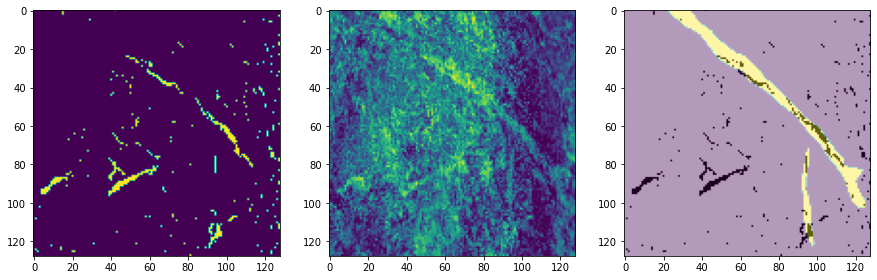

In [74]:
y_hat = unet(torch.tensor(image,dtype = torch.float).unsqueeze(0).unsqueeze(0))

fig, ax = plt.subplots(1,3, figsize = (15,8))
pred = y_hat[0,0,:].detach().numpy() 
pred[pred>0.1] = 1
pred[pred<0.1] = 0

ax[0].imshow(pred)
ax[1].imshow(image)
ax[2].imshow(test['mask'])
ax[2].imshow(pred, alpha = 0.6, cmap='Greys')

In [75]:
def iou(i,t):
    i = i.reshape(-1,1)
    t = t.reshape(-1,1)
    t = np.array(t).astype(int)
    intersection = (i*t).sum()
    dice = 2.*intersection/(i.sum() + t.sum())
    return dice

def prosses(y):
    def f():
        y[y>0.1] = 1
        y[y<0.1] = 0
        return y
    return f

arr_iou = np.zeros((len(dataset_test),1))
for k, ex in enumerate(dataset_test): 
    image = ex['image']
    mask  = ex['mask']
    y_hat = unet(torch.tensor(image,dtype = torch.float).unsqueeze(0).unsqueeze(0))

    pred = prosses(y_hat[0,0,:].detach().numpy())()
    r = iou(pred, np.invert(mask.astype(bool)).astype(int))
    arr_iou[k,0] = r
    print(ex['path'],r)

0_IMG_2631.JPG 0.021775544388609715
0_IMG_2632.JPG 0.058507313414176775
0_IMG_2633.JPG 0.05651618112090426
0_IMG_2634.JPG 0.02865138592750533
0_IMG_2635.JPG 0.019202363367799114
0_IMG_2636.JPG 0.04777819037009531
0_IMG_2637.JPG 0.05240058518420003
0_IMG_2638.JPG 0.05984332862463079
0_IMG_2639.JPG 0.058677793714956315
0_IMG_2640.JPG 0.05972645284596548
0_IMG_2641.JPG 0.05704657600192562
0_IMG_2642.JPG 0.029669762641898866
0_IMG_2643.JPG 0.03547582113711472
0_IMG_2644.JPG 0.04573228346456693
0_IMG_2645.JPG 0.04802656788861923
0_IMG_2646.JPG 0.05279713809905631
0_IMG_2647.JPG 0.04059962523422861
0_IMG_2648.JPG 0.03346685618296938
0_IMG_2649.JPG 0.02154517216310885
1_IMG_2631.JPG 0.0444104134762634
1_IMG_2632.JPG 0.05998125585754452
1_IMG_2633.JPG 0.05666218034993271
1_IMG_2634.JPG 0.021360389827114346
1_IMG_2635.JPG 0.016972936852656197
1_IMG_2636.JPG 0.03929346141927487
1_IMG_2637.JPG 0.05277851635203403
1_IMG_2638.JPG 0.0685597339473011
1_IMG_2639.JPG 0.055784179240969366
1_IMG_2640.JPG

KeyboardInterrupt: 

In [45]:
arr_iou.mean()

0.04498461329651396

In [99]:
img.shape

(128, 128)

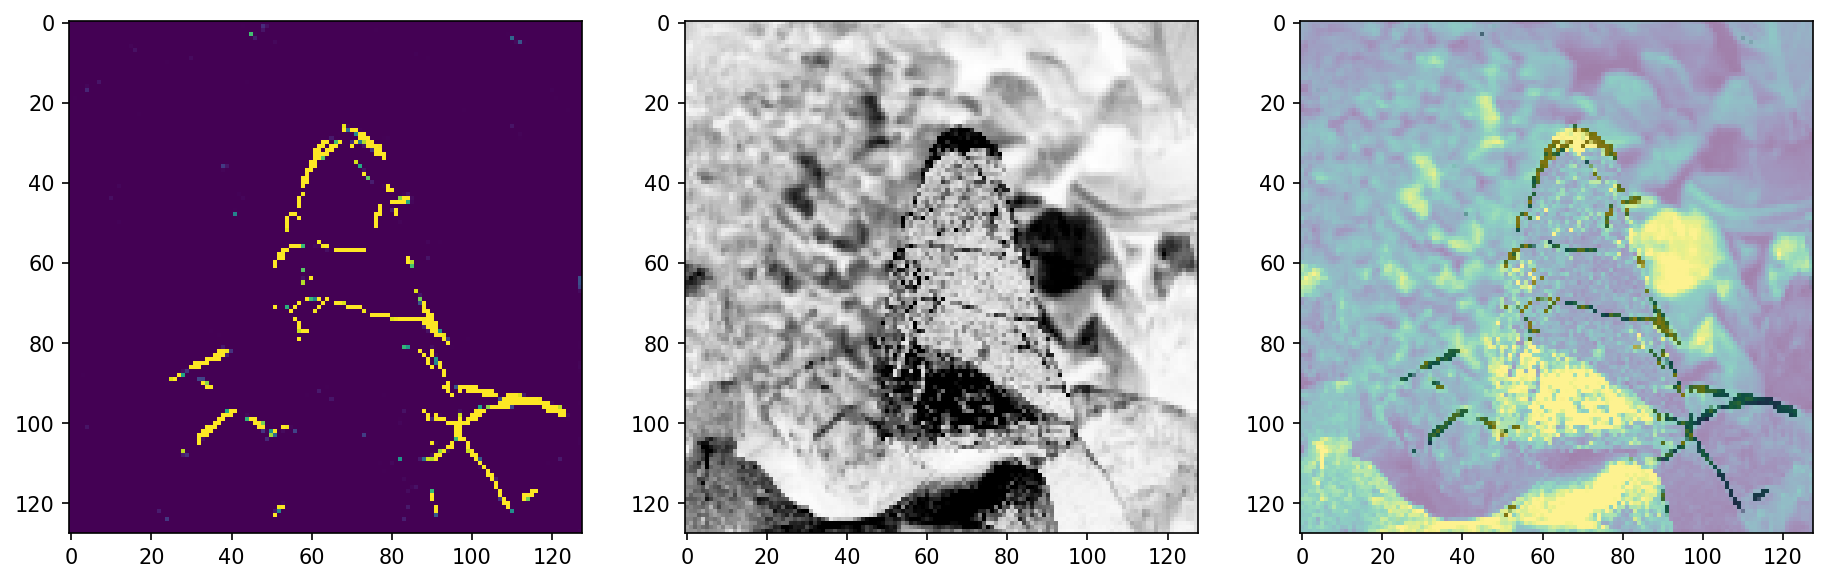

In [148]:
img = load_img('/home/kirill/Учеба/asbestos/PitStonesData/asbestos_stone_161220/images/asbestos/stones/161220/ManualDetailedImage_10_04_15.bmp', float)
img = img/img.max()
img = cv2.resize(img, (128,128))
img = img.astype(np.float32)
y_  = unet(torch.tensor(img).unsqueeze(0).unsqueeze(1))
pred = y_[0,0,:].detach().numpy() 

fig, ax = plt.subplots(1,3, figsize = (15,8), dpi = 150)
ax[0].imshow(pred)
ax[1].imshow(img*255, cmap = 'Greys')
ax[2].imshow(img)
ax[2].imshow(pred, alpha = 0.5, cmap = 'Greys')



In [149]:
img*255

array([[ 95.8125,  92.0625,  81.625 , ..., 106.1875,  96.0625,  95.375 ],
       [ 98.5   ,  87.75  ,  79.3125, ..., 106.4375,  95.5   , 103.25  ],
       [ 94.375 ,  88.375 ,  80.5   , ..., 102.25  ,  96.8125, 104.5   ],
       ...,
       [155.125 , 132.5   , 170.3125, ...,  53.9375,  61.875 ,  70.5625],
       [132.0625, 150.375 , 177.1875, ...,  44.25  ,  49.9375,  67.0625],
       [141.1875, 143.25  , 140.9375, ...,  50.3125,  55.    ,  65.6875]],
      dtype=float32)

In [1]:
img = load_img('/home/kirill/Учеба/asbestos/PitStonesData/asbestos_stone_161220/images/asbestos/stones/161220/ManualDetailedImage_10_04_15.bmp')
t = np.zeros((img.shape[0], img.shape[1], 3))
t[:,:,0] = img
# t[]
plt.imshow(t)

NameError: name 'load_img' is not defined

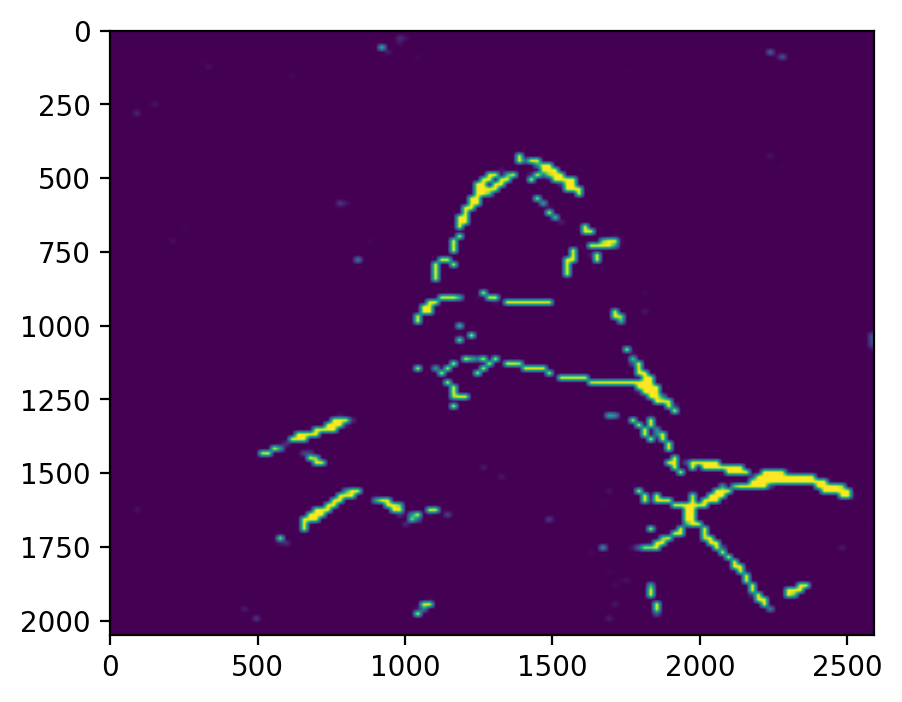

In [165]:
plt.figure(dpi = 200)
plt.imshow(cv2.resize(pred*255, img.T.shape))

In [1]:
import wget

In [3]:
wget.download("https://aspirant.urfu.ru/ru/aspirantura/kandidatskie-ehkzameny/",'')

'download.wget'